## Image Captioning
- Generating Captions for Images

### Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

In [3]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions


In [4]:
captions  = readTextFile("/content/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [5]:
print(len(captions))

40460


In [6]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
# Dictionary to Map each Image with the list of captions it has

In [8]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]

    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(second)

In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

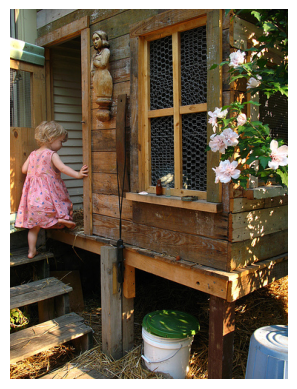

In [10]:
IMG_PATH = "/content/drive/MyDrive/Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()



### Data Cleaning


In [11]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence


In [12]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [13]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [14]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [16]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [17]:
print(type(descriptions))

<class 'dict'>


In [18]:
# Vocab(How many diffrent words in this descriptions)

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [19]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))


Total Words 373837


In [20]:
# Filter Words from the Vocab according to certain threshold frequncy

In [21]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [22]:
freq_cnt

{'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fingerpaints': 3,

In [23]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold] # take most frequent word(freq>10)
total_words = [x[0] for x in sorted_freq_cnt]

In [24]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [25]:
train_file_data = readTextFile("/content/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/Flickr_8k.testImages.txt")

In [26]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]# remove .jpg tag from images
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [27]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [28]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [29]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features

### Step - 1 Image Feature Extraction

In [30]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [31]:
model_new = Model(model.input,model.layers[-2].output)   #Remove last two layer Resnet bcz we not doing classification task

In [32]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

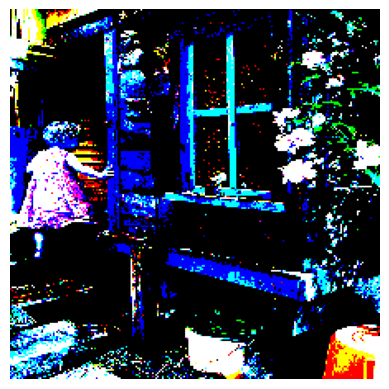

In [33]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [34]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [35]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step


array([0.06536547, 0.1678271 , 0.32518455, ..., 0.05111531, 0.32817906,
       1.0043341 ], dtype=float32)

In [36]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken :",end_t-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 187ms/step
Encoding in Progress Time step 1100 
1/1 [==============================] - 0s 192ms/step
Encoding in Progress Time step 1200 
1/1 [==============================] - 0s 182ms/step
Encoding in Progress Time step 1300 
1/1 [==============================] - 0s 180ms/step
Encoding in Progress Time step 1400 
1/1 [==============================] - 0s 173ms/step
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 192ms/step
Encoding in Progress Time step 1600 
1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 1700 
1/1 [==============================] - 0s 192ms/step
Encoding in Progress Time step 1800 
1/1 [==============================] - 0s 300ms/step
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 306ms/step
Encoding in Progress Time step 2000 
1/1 [==============================] - 0s 355ms/s

In [37]:
!mkdir saved

In [38]:
# Store everything to the disk
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [39]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken(test) :",end_t-start)

1/1 [==============================] - 0s 311ms/step
Test Encoding in Progress Time step 0 
1/1 [==============================] - 0s 351ms/step
Test Encoding in Progress Time step 100 
1/1 [==============================] - 0s 195ms/step
Test Encoding in Progress Time step 200 
1/1 [==============================] - 0s 193ms/step
Test Encoding in Progress Time step 300 
1/1 [==============================] - 0s 209ms/step
Test Encoding in Progress Time step 400 
1/1 [==============================] - 0s 314ms/step
Test Encoding in Progress Time step 500 
1/1 [==============================] - 0s 360ms/step
Test Encoding in Progress Time step 600 
1/1 [==============================] - 0s 171ms/step
Test Encoding in Progress Time step 700 
1/1 [==============================] - 0s 186ms/step
Test Encoding in Progress Time step 800 
1/1 [==============================] - 0s 184ms/step
Test Encoding in Progress Time step 900 
1/1 [==============================] - 0s 192ms/step
Total Tim

In [40]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [41]:
# Vocab
len(total_words)

1845

In [42]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [43]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [44]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [45]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


### Data Loader (Generator)

In [46]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]

    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            if key + ".jpg" in encoding_train:
              photo = encoding_train[key+".jpg"]
              for desc in desc_list:

                  seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                  for i in range(1,len(seq)):
                      xi = seq[0:i]
                      yi = seq[i]

                      #0 denote padding word
                      xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                      yi = to_categorcial([yi],num_classes=vocab_size)[0]

                      X1.append(photo)                          # x1 has features embeddings of pic
                      X2.append(xi)                             # x2 has embeddings from starting to (i-1)th word embeddings
                      y.append(yi)                              # y has ith word embeddings

                  if n==batch_size:
                      yield [[np.array(X1),np.array(X2)],np.array(y)]
                      X1,X2,y = [],[],[]
                      n = 0

## Word Embeddings

In [48]:
f = open("./glove.6B.50d.txt",encoding='utf8') # unique word and their word embeddings in a row

In [49]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]    # word
    word_embedding = np.array(values[1:],dtype='float')  # and their wmbeddingd
    embedding_index[word] = word_embedding  # store in list

In [50]:
f.close()

In [51]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [52]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix

embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [53]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Model Architecture

In [54]:
# Image features as Input
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [55]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)  # covert into embeddings
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)  # give to Lstm

In [56]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [58]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [59]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [64]:
epochs = 20
batch_size = 3
number_pics_per_batch = 10
steps = len(train_descriptions)//number_pics_per_batch


In [65]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [66]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [67]:
def predict_caption(photo):

    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)

        if word == "endseq":
            break

    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

<ipython-input-69-f0ca8185718e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


1/1 [==============================] - 0s 42ms/step


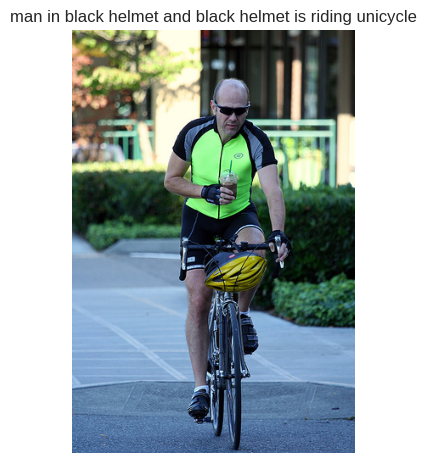

1/1 [==============================] - 0s 41ms/step


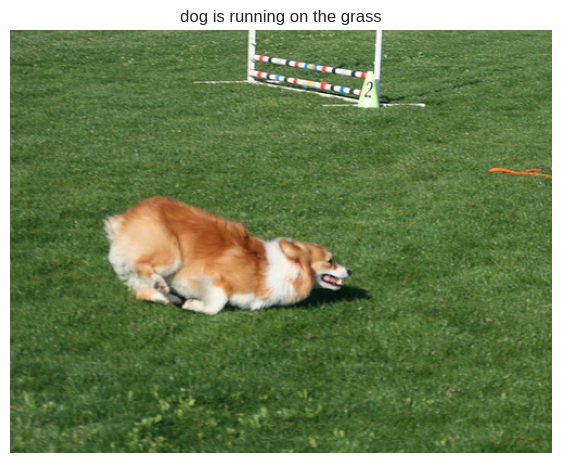

1/1 [==============================] - 0s 43ms/step


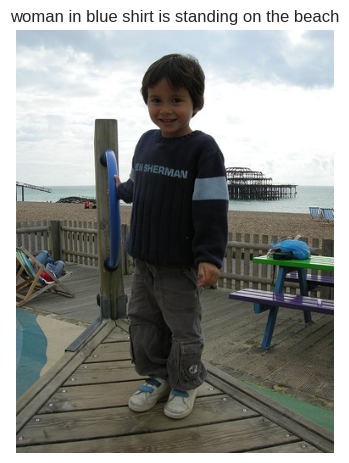

1/1 [==============================] - 0s 44ms/step


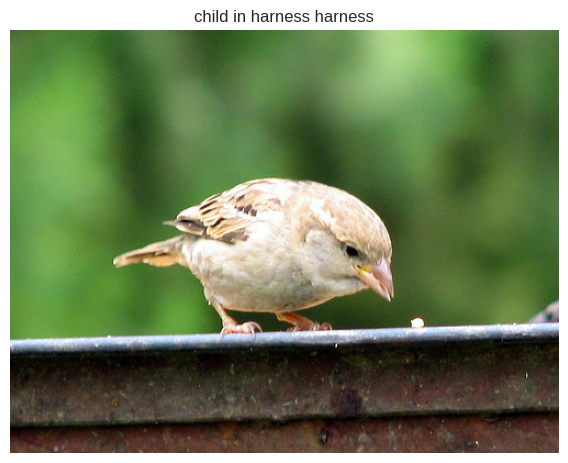

1/1 [==============================] - 0s 51ms/step


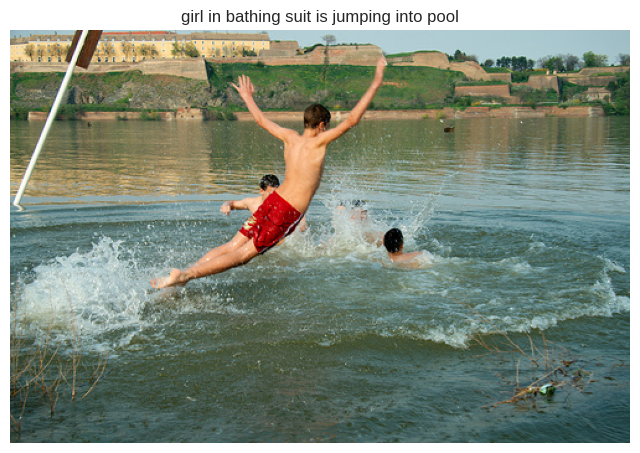

1/1 [==============================] - 0s 51ms/step


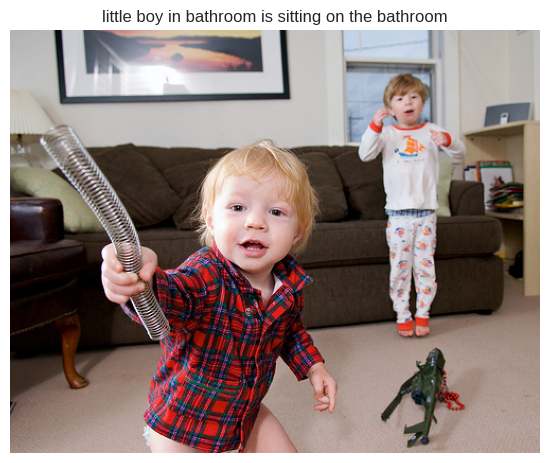

1/1 [==============================] - 0s 73ms/step


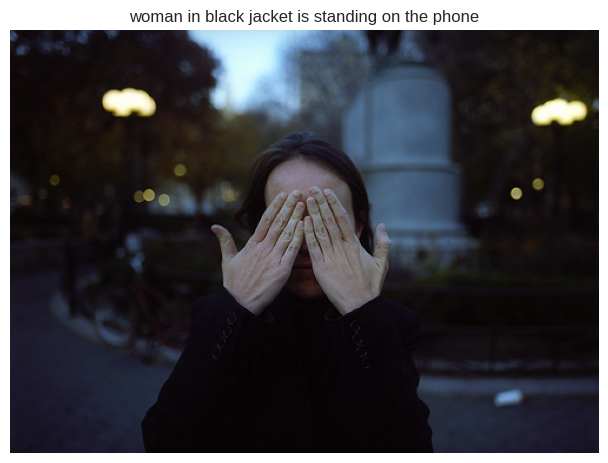

1/1 [==============================] - 0s 79ms/step


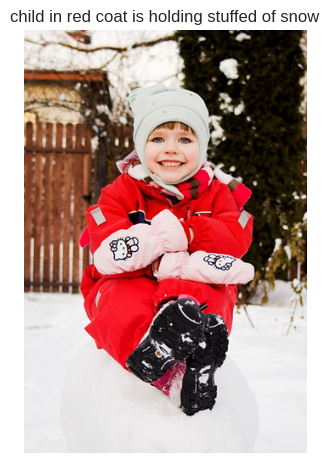

1/1 [==============================] - 0s 67ms/step


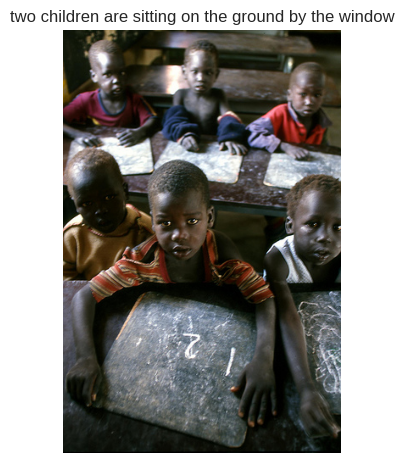

1/1 [==============================] - 0s 117ms/step


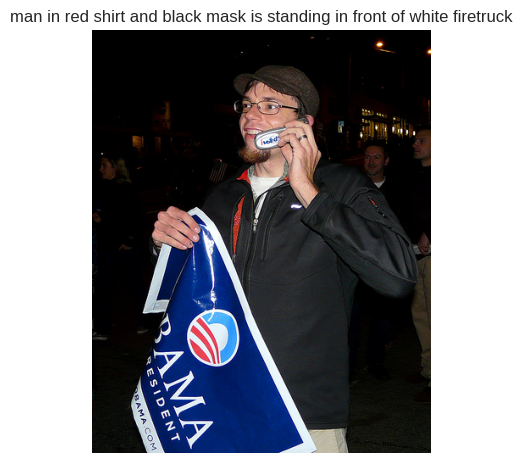

1/1 [==============================] - 0s 57ms/step


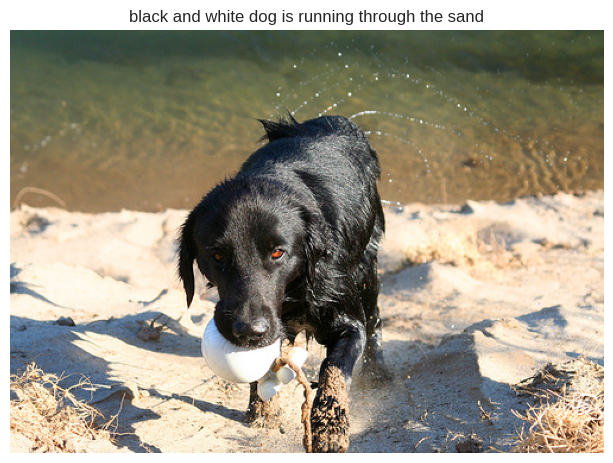

1/1 [==============================] - 0s 70ms/step


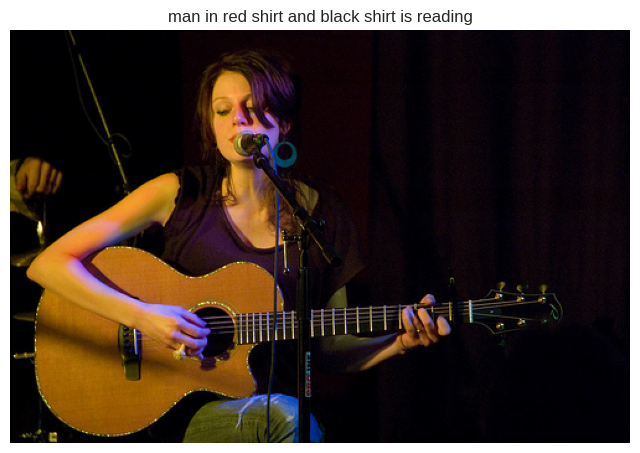

1/1 [==============================] - 0s 69ms/step


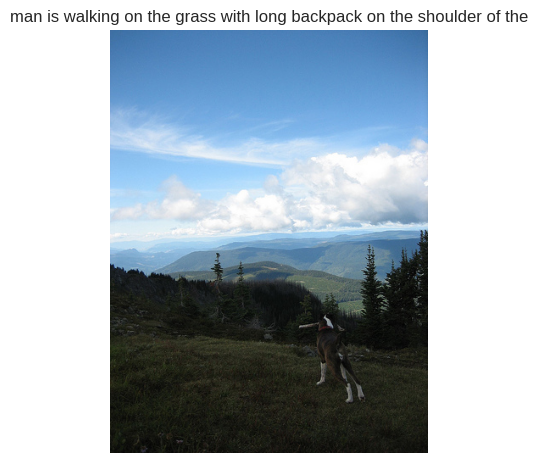

1/1 [==============================] - 0s 70ms/step


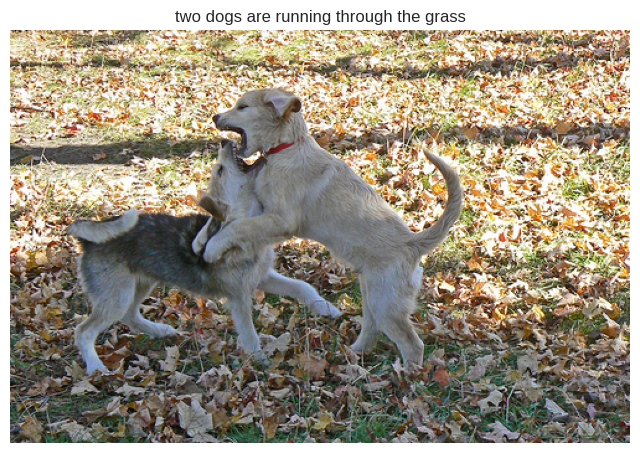

1/1 [==============================] - 0s 110ms/step


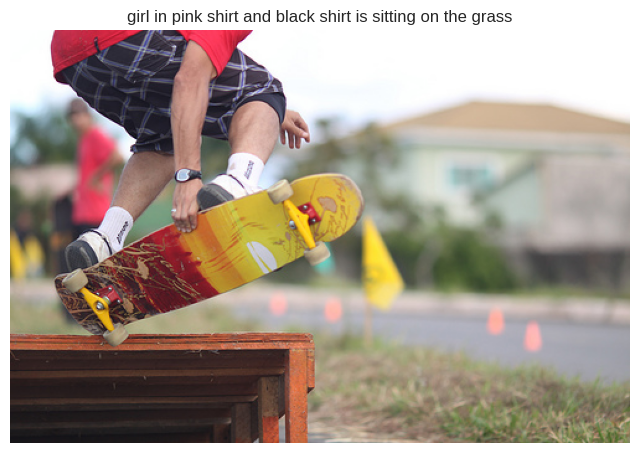

In [69]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH+img_name+".jpg")

    caption = predict_caption(photo_2048)
    #print(caption)

    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()


In [70]:
encoding_test["3385593926_d3e9c21170"].shape

(2048,)